In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## method definition

In [2]:
def count_t_f(df_labels, df_predictions):
    # compare labels with prediction of gemini 
    false_count = 0
    true_count = 0
    for index, row in df_labels.iterrows():
        if row['img_name'] in df_predictions['img_name'].values:
            model_row = df_predictions.loc[df_predictions['img_name'] == row['img_name']]
            # print(f"row: {row['text_sentiment'].lower()} vs. model row: {model_row['text_sent'].values[0]}")
            if row['text_sentiment'] == model_row['text_sent'].values[0]:
                true_count += 1
            else:
                false_count += 1

    print("True: ", true_count)
    print("False: ", false_count)


def plot_conf_matrix(df_labels, df_predictions):
    # Merge the dataframes on the 'image' and 'img_name' columns to align them
    merged_df = pd.merge(df_labels, df_predictions, left_on='img_name', right_on='img_name', how='inner')

    # Define the possible categories
    truth_categories = ['Positive',  'Neutral', 'Negative']
    prediction_categories = ['Positive',  'Neutral', 'Negative']

    # Initialize the confusion matrix
    conf_matrix = np.zeros((len(truth_categories), len(prediction_categories)), dtype=int)

    # Fill the confusion matrix
    for _, row in merged_df.iterrows():
        truth = row['text_sentiment']
        pred = row['text_sent']
        if pred in prediction_categories:
            i = truth_categories.index(truth)
            j = prediction_categories.index(pred)
            conf_matrix[i, j] += 1

    # Convert the confusion matrix to a DataFrame for better readability
    conf_matrix_df = pd.DataFrame(conf_matrix, index=truth_categories, columns=prediction_categories)

    # Display the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return conf_matrix

def calc_metrics(conf_matrix):
    # Calculate metrics from confusion matrix
    truth_categories = ['Positive',  'Neutral', 'Negative']
    total_samples = conf_matrix.sum()
    correct_predictions = np.trace(conf_matrix)
    accuracy = correct_predictions / total_samples

    precision = {}
    recall = {}
    f1_score = {}

    for i, category in enumerate(truth_categories):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        precision[category] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[category] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score[category] = 2 * (precision[category] * recall[category]) / (precision[category] + recall[category]) if (precision[category] + recall[category]) > 0 else 0


    # Display metrics
    print(f"Accuracy: {accuracy:.2f}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)

In [3]:
df_labels = pd.read_excel("labeled_subset_500.xlsx")

#remove all columns but img_name, tweet_id, text_sentiment, image_sentiment by name
df_labels.drop(columns=['created_at', 'language', 'like_count', 'quote_count', 'referenced_tweets', 'retweet_count', 'text', 'recheck_needed'], axis=1, inplace=True)
df_labels.drop(df_labels.columns[4:], axis=1, inplace=True)

In [4]:
# trim whitespaces from image_sentiment and text_sentiment
df_labels['image_sentiment'] = df_labels['image_sentiment'].str.strip()
df_labels['text_sentiment'] = df_labels['text_sentiment'].str.strip()
df_labels.describe(include='all')


,img_name,tweet_id,text_sentiment,image_sentiment
count,500,5.000000e+02,500,500
unique,500,NaN,3,3
top,id_1103707209022783488_2019-03-07.jpg,NaN,Neutral,Neutral
freq,1,NaN,198,229
mean,NaN,1.150498e+18,NaN,NaN
std,NaN,3.643419e+16,NaN,NaN
min,NaN,1.080492e+18,NaN,NaN
25%,NaN,1.121437e+18,NaN,NaN
50%,NaN,1.152433e+18,NaN,NaN
75%,NaN,1.180680e+18,NaN,NaN


In [5]:
# load roBERTa predictions
roberta = pd.read_csv("results_text/results_text_roberta.csv")
roberta = roberta.drop_duplicates() 

In [6]:
roberta.head()

,created_at,img_name,language,like_count,quote_count,referenced_tweets,retweet_count,text,tweet_id,Negative,Neutral,Positive,text_sent
0,2019-07-22T12:38:24.000Z,id_1153283149360762880_2019-07-22.jpg,en,82582,3918,NaN,50280,the UN released a 740 page report compiled ove...,1153283149360762880,0.702820,0.273529,0.023651,Negative
1,2019-08-20T09:28:39.000Z,id_1163744643600637952_2019-08-20.jpg,en,69820,2456,NaN,51781,"The Amazon Rainforest, one of the wettest plac...",1163744643600637952,0.936377,0.057425,0.006198,Negative
2,2019-04-28T18:51:22.000Z,id_1122574040936452097_2019-04-28.jpg,en,69235,87,NaN,11051,just learned about climate change https://t.co...,1122574040936452097,0.194377,0.751199,0.054424,Neutral
3,2019-10-28T13:10:13.000Z,id_1188805167958974465_2019-10-28.jpg,en,65465,70,NaN,6124,Climate change caused this. https://t.co/JG2Ly...,1188805167958974465,0.654834,0.322148,0.023018,Negative
4,2019-03-19T16:30:00.000Z,id_1108042949449969666_2019-03-19.jpg,en,62852,976,NaN,9145,#GreenNewDeal haters\xe2\x80\x99 plan to addre...,1108042949449969666,0.646412,0.322033,0.031555,Negative


In [7]:
count_t_f(df_labels, roberta)

True:  331
False:  169


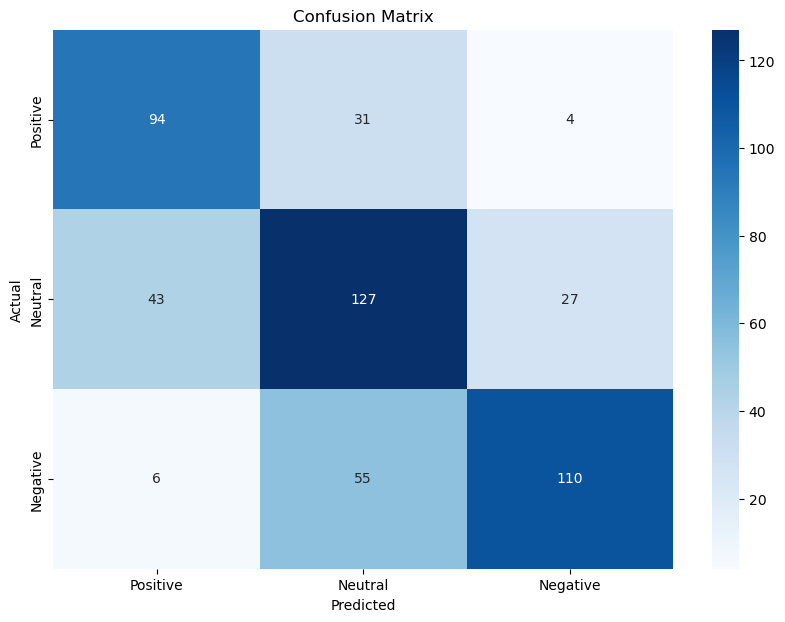

In [8]:
conf_matrix = plot_conf_matrix(df_labels, roberta)

In [9]:
calc_metrics(conf_matrix)

Accuracy: 0.67
Precision: {'Positive': 0.6573426573426573, 'Neutral': 0.596244131455399, 'Negative': 0.7801418439716312}
Recall: {'Positive': 0.7286821705426356, 'Neutral': 0.6446700507614214, 'Negative': 0.6432748538011696}
F1 Score: {'Positive': 0.6911764705882353, 'Neutral': 0.6195121951219512, 'Negative': 0.705128205128205}


## Text vs Image (Gemini)

In [26]:
gemini = pd.read_csv('results/responses_subset_small_all_results_updated.csv')
gemini = gemini.drop_duplicates()
gemini.head()

,image,sentiment,confidence,explanation
0,id_1087717020001542151_2019-01-22.jpg,negative,1.0,'There is no planet B' suggests that Earth is ...
1,id_1105854449824792576_2019-03-13.jpg,prediction failed,0.0,No sentiment detected.
2,id_1088764632901259264_2019-01-25.jpg,negative,0.9,The image shows a group of people who are cons...
3,id_1086040260704985088_2019-01-17.jpg,negative,0.9,The image shows a comparison between the Arcti...
4,id_1106631808890867714_2019-03-15.jpg,positive,0.9,The image shows a group of children holding si...


In [44]:
roberta = roberta.drop_duplicates()
df_labels = df_labels.drop_duplicates()
all_df = pd.merge(df_labels, gemini, left_on='img_name', right_on='image', how='inner')

In [45]:
all_df = pd.merge(all_df, roberta, left_on='img_name', right_on='img_name', how='inner')
all_df.head()

,img_name,tweet_id_x,text_sentiment,image_sentiment,image,sentiment,confidence,explanation,created_at,language,like_count,quote_count,referenced_tweets,retweet_count,text,tweet_id_y,Negative,Neutral,Positive,text_sent
0,id_1103707209022783488_2019-03-07.jpg,1103707209022783488,Positive,Positive,id_1103707209022783488_2019-03-07.jpg,positive,0.9,The image shows three men in suits smiling and...,2019-03-07T17:21:19.000Z,en,428,9,NaN,97,Had a good chat with \xe2\x81\xa6@ChrisEvans\x...,1103707209022783488,0.042109,0.233280,0.724611,Positive
1,id_1119275549766180864_2019-04-19.jpg,1119275549766180864,Neutral,Neutral,id_1119275549766180864_2019-04-19.jpg,negative,0.8,The image is about a report on how British com...,2019-04-19T16:24:20.000Z,en,269,20,NaN,269,City of London is massive contributor to clima...,1119275549766180864,0.481704,0.473073,0.045223,Negative
2,id_1081406708436688896_2019-01-05.jpg,1081406708436688896,Neutral,Positive,id_1081406708436688896_2019-01-05.jpg,positive,0.9,"The image shows a group of people, including A...",2019-01-05T04:27:05.000Z,en,261,24,NaN,50,Democratic Rep. Alexandria Ocasio-Cortez propo...,1081406708436688896,0.100733,0.822879,0.076389,Neutral
3,id_1089285642826088448_2019-01-26.jpg,1089285642826088448,Neutral,Positive,id_1089285642826088448_2019-01-26.jpg,positive,0.9,The man in the picture is smiling and clapping...,2019-01-26T22:15:09.000Z,en,593,31,NaN,114,"Austrian muscleman, movie star and former Cali...",1089285642826088448,0.549824,0.419548,0.030628,Negative
4,id_1156199327586488320_2019-07-30.jpg,1156199327586488320,Positive,Positive,id_1156199327586488320_2019-07-30.jpg,positive,0.9,The image shows a man and a woman smiling at e...,2019-07-30T13:46:15.000Z,en,844,20,NaN,194,\\We\xe2\x80\x99ve stolen their future. Not al...,1156199327586488320,0.313418,0.577666,0.108917,Neutral


In [46]:

def lower(text):
    text = str(text)
    # text = text.strip()
    return text.lower()

In [47]:
# compare how often text sentiment and image sentiment are the same

all_df = all_df.drop(columns=['image', 'created_at', 'language', 'like_count', 'quote_count', 'referenced_tweets', 'retweet_count', 'tweet_id_y', 'Negative', 'Neutral', 'Positive' ])

all_df['text_sent'] = all_df['text_sent'].apply(lower)

same_sentiments = all_df[all_df['sentiment'] == all_df['text_sent']]
different_sentiments = all_df[all_df['sentiment'] != all_df['text_sent']]

same_count = len(same_sentiments)
different_count = len(different_sentiments)

total_count = len(all_df)

same_percentage = (same_count / total_count) * 100
different_percentage = (different_count / total_count) * 100

print(f"Same Sentiments: {same_count} ({same_percentage:.2f}%)")
print(f"Different Sentiments: {different_count} ({different_percentage:.2f}%)")




Same Sentiments: 209 (41.80%)
Different Sentiments: 291 (58.20%)


In [48]:
pos_neg = all_df[(all_df['text_sent'] == 'positive') & (all_df['sentiment'] == 'negative')]
neg_pos = all_df[(all_df['text_sent'] == 'negative') & (all_df['sentiment'] == 'positive')]
opposite_text_image = pos_neg.append(neg_pos)

# print(opposite_text_image.shape)

opposite_text_image.head()


/var/folders/7d/fb5mpywx6zdbz73hljh_23pm0000gn/T/ipykernel_83415/2098808028.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  opposite_text_image = pos_neg.append(neg_pos)


,img_name,tweet_id_x,text_sentiment,image_sentiment,sentiment,confidence,explanation,text,text_sent
37,id_1135338792095633408_2019-06-03.jpg,1135338792095633408,Positive,Negative,negative,0.8,The image shows a person holding a sign that s...,When PM Scott Morrison arrived in the #Solomon...,positive
51,id_1162027899668586504_2019-08-15.jpg,1162027899668586504,Neutral,Neutral,negative,0.8,"The image shows a glacier breaking apart, whic...",Meteorologists say July was the hottest month ...,positive
78,id_1205410591185096709_2019-12-13.jpg,1205410591185096709,Neutral,Neutral,negative,0.9,The image is a table of the Climate Change Per...,"b""#India ranks among top 10 in this year's #Cl...",positive
82,id_1177304883604656128_2019-09-26.jpg,1177304883604656128,Positive,Positive,negative,0.6,The image is about a woman giving a speech abo...,Delighted to attend the wonderful and vibrant ...,positive
84,id_1196919169037541376_2019-11-19.jpg,1196919169037541376,Neutral,Negative,negative,0.8,The image is of a woman smoking and looking do...,"b""me: 90s sitcom dinosaurs is underrated, not ...",positive


In [49]:
opposite_text_image.head()

,img_name,tweet_id_x,text_sentiment,image_sentiment,sentiment,confidence,explanation,text,text_sent
37,id_1135338792095633408_2019-06-03.jpg,1135338792095633408,Positive,Negative,negative,0.8,The image shows a person holding a sign that s...,When PM Scott Morrison arrived in the #Solomon...,positive
51,id_1162027899668586504_2019-08-15.jpg,1162027899668586504,Neutral,Neutral,negative,0.8,"The image shows a glacier breaking apart, whic...",Meteorologists say July was the hottest month ...,positive
78,id_1205410591185096709_2019-12-13.jpg,1205410591185096709,Neutral,Neutral,negative,0.9,The image is a table of the Climate Change Per...,"b""#India ranks among top 10 in this year's #Cl...",positive
82,id_1177304883604656128_2019-09-26.jpg,1177304883604656128,Positive,Positive,negative,0.6,The image is about a woman giving a speech abo...,Delighted to attend the wonderful and vibrant ...,positive
84,id_1196919169037541376_2019-11-19.jpg,1196919169037541376,Neutral,Negative,negative,0.8,The image is of a woman smoking and looking do...,"b""me: 90s sitcom dinosaurs is underrated, not ...",positive


In [50]:
# filter for opposite sentiments and "correct" labelling

opposite_text_image['image_sentiment'] = opposite_text_image['image_sentiment'].apply(lower)
opposite_text_image['text_sentiment'] = opposite_text_image['text_sentiment'].apply(lower)

checked = opposite_text_image[(opposite_text_image['text_sent'] == opposite_text_image['text_sentiment']) & (opposite_text_image['sentiment'] == opposite_text_image['image_sentiment'])]
checked

,img_name,tweet_id_x,text_sentiment,image_sentiment,sentiment,confidence,explanation,text,text_sent
37,id_1135338792095633408_2019-06-03.jpg,1135338792095633408,positive,negative,negative,0.8,The image shows a person holding a sign that s...,When PM Scott Morrison arrived in the #Solomon...,positive
213,id_1175523793281998848_2019-09-21.jpg,1175523793281998848,positive,negative,negative,0.9,The image is about climate change and it says ...,We need to agree unequivocally on the need for...,positive
222,id_1118532300860477441_2019-04-17.jpg,1118532300860477441,positive,negative,negative,0.9,The article is about light pollution and how i...,"With all the papers full of Brexit, Climate ch...",positive
474,id_1197070620409946117_2019-11-20.jpg,1197070620409946117,positive,negative,negative,0.9,The image is of a skeleton with a black backgr...,\xe2\x80\x9cThis new Soweto Kinch album is the...,positive
59,id_1102081658944073729_2019-03-03.jpg,1102081658944073729,negative,positive,positive,0.9,The image shows a group of people hugging and ...,The 2014 repeal of the Carbon Price was the Li...,negative
153,id_1135951124945674241_2019-06-04.jpg,1135951124945674241,negative,positive,positive,0.6,The image shows a group of people gathered in ...,We stand here in solidarity with all those peo...,negative
174,id_1169009784516939776_2019-09-03.jpg,1169009784516939776,negative,positive,positive,0.9,The image shows Ivanka Trump smiling and walki...,"b""Is Ivanka's dress: made from Kermit? Morphin...",negative
264,id_1107395909464125440_2019-03-17.jpg,1107395909464125440,negative,positive,positive,0.9,The image shows a group of people riding bicyc...,"b""Seriously Australia. How can this be illegal...",negative
273,id_1190515268356755461_2019-11-02.jpg,1190515268356755461,negative,positive,positive,0.9,The image shows Leonardo DiCaprio and Greta Th...,You still flying on that private jet and cruis...,negative
372,id_1097353753831780352_2019-02-18.jpg,1097353753831780352,negative,positive,positive,0.6,The image shows a flower that looks like a pai...,"I\'ve found it, my least favourite plant: psyc...",negative


In [51]:
all_df.rename(columns={'text_sentiment': 'text_sentiment_label', 'image_sentiment': 'image_sentiment_label', 'sentiment': 'image_sentiment', 'text_sent': 'text_sentiment'}, inplace=True)
all_df.head()

,img_name,tweet_id_x,text_sentiment_label,image_sentiment_label,image_sentiment,confidence,explanation,text,text_sentiment
0,id_1103707209022783488_2019-03-07.jpg,1103707209022783488,Positive,Positive,positive,0.9,The image shows three men in suits smiling and...,Had a good chat with \xe2\x81\xa6@ChrisEvans\x...,positive
1,id_1119275549766180864_2019-04-19.jpg,1119275549766180864,Neutral,Neutral,negative,0.8,The image is about a report on how British com...,City of London is massive contributor to clima...,negative
2,id_1081406708436688896_2019-01-05.jpg,1081406708436688896,Neutral,Positive,positive,0.9,"The image shows a group of people, including A...",Democratic Rep. Alexandria Ocasio-Cortez propo...,neutral
3,id_1089285642826088448_2019-01-26.jpg,1089285642826088448,Neutral,Positive,positive,0.9,The man in the picture is smiling and clapping...,"Austrian muscleman, movie star and former Cali...",negative
4,id_1156199327586488320_2019-07-30.jpg,1156199327586488320,Positive,Positive,positive,0.9,The image shows a man and a woman smiling at e...,\\We\xe2\x80\x99ve stolen their future. Not al...,neutral


In [52]:
all_df.to_csv('sentiment_analysis_compact.csv')